<a href="https://colab.research.google.com/github/aaronmj7/Assignment-3-LLM/blob/main/Assignment_3_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3 - Large language models**


Name: Aaron Modiyil Joseph <br>
Student ID: 22018497

In [ ]:
# Install necessary libraries
!pip install datasets evaluate transformers[sentencepiece]
# Clear the output
from IPython.display import clear_output
clear_output()

In [ ]:
# Import necessary libraries
import seaborn as sns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification, create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report

import ipywidgets as widgets

In [ ]:
# Set seaborn theme
sns.set_theme()

# Ignore warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [ ]:
# Load dataset
raw_ds = load_dataset("OxAISH-AL-LLM/wiki_toxic")

Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

In [ ]:
# Display the datasest
raw_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [ ]:
# Display features
raw_ds["train"].features

{'id': Value(dtype='string', id=None),
 'comment_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['non', 'tox'], id=None)}

In [ ]:
# Extract label names
label_names = raw_ds["train"].features['label'].names
label_names

['non', 'tox']

In [ ]:
# Display the first element of the training dataset
raw_ds["train"][0]

{'id': '794c30aff0931384',
 'comment_text': "And that's not a personal attack^^ ?",
 'label': 0}

In [ ]:
# We are only using the balanced training dataset
ds = raw_ds["balanced_train"]
ds

Dataset({
    features: ['id', 'comment_text', 'label'],
    num_rows: 25868
})

In [ ]:
# Display the first five elements
ds[:5]

{'id': ['653b15d1deea659e',
  '57c5f0e88e9e5219',
  'e78a6eb06dbddd9a',
  '435008cc6f750098',
  '2c60f0fc97d86718'],
 'comment_text': ['"\nNot if I can help it. Mudslide is more like it....127 "',
  'Footnotes/references\nOk. I have no objection',
  '.\nI am a loser and I need your help to get a life',
  '"\nI think I\'ve decided that I have no strong opinion. As long as the style doesn\'t have any of the old problems, it doesn\'t matter to me if it\'s substed or transcluded. Just no metadata, no hide/show, and no junk links. -  (conspire | past ops) "',
  'Quite frankly nothing is helping due to his arrogance and truculence. He keeps getting called a dick as he is acting like one, over and over. In my view that makes him one. Thank you for posting my comment over to the IB. Incidentally, what makes you think a block will cure anything?'],
 'label': [0, 0, 0, 0, 1]}

## **EDA**

In [ ]:
# Convert dataset to DataFrame
ds.set_format("pandas")
df = ds[:]

# Reset dataset format
ds.reset_format()

# Display first few rows
df.head()

,id,comment_text,label
0,653b15d1deea659e,"""\nNot if I can help it. Mudslide is more like...",0
1,57c5f0e88e9e5219,Footnotes/references\nOk. I have no objection,0
2,e78a6eb06dbddd9a,.\nI am a loser and I need your help to get a ...,0
3,435008cc6f750098,"""\nI think I've decided that I have no strong ...",0
4,2c60f0fc97d86718,Quite frankly nothing is helping due to his ar...,1


In [ ]:
# Drop the 'id' column
try:
    df.drop(columns=['id'], inplace=True)
except KeyError:
    pass
df.head()

,comment_text,label
0,"""\nNot if I can help it. Mudslide is more like...",0
1,Footnotes/references\nOk. I have no objection,0
2,.\nI am a loser and I need your help to get a ...,0
3,"""\nI think I've decided that I have no strong ...",0
4,Quite frankly nothing is helping due to his ar...,1


label
0    12934
1    12934
Name: count, dtype: int64


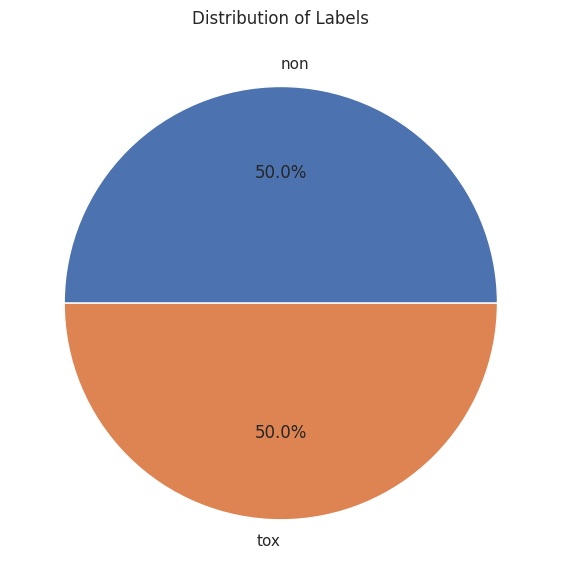

In [ ]:
# Calculate the proportions of each label
label_counts = df['label'].value_counts()
sizes = label_counts.values.tolist()
print(label_counts)

# PLot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=label_names, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.tight_layout()
plt.show()

In [ ]:
# Define a function for generating WordCloud
def generate_word_cloud(df, label):
    """
    Generates a WordCloud for either toxic or non-toxic comments based on the
    specified label.

    Args:
        df: DataFrame containing comment data.
        label: Label indicating whether to extract toxic (1) or
                     non-toxic (0) comments.

    Returns:
        None: Displays the WordCloud image.
    """
    # Get the text for the specified label
    text = ''.join(df[df['label'] == label]['comment_text'])
    # Convert the text to lowercase
    text = text.lower()
    # Generate a WordCloud
    wordcloud = WordCloud(width=900, height=450,
                          background_color="white").generate(text)

    # Display the WordCloud image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if label == 1:
        plt.title("Word Cloud For Toxic Comments")
    else:
        plt.title("Word Cloud For Non-Toxic Comments")
    plt.show()
    return

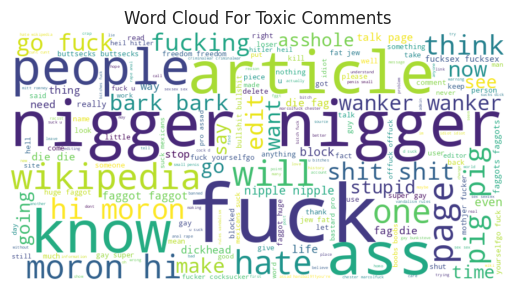

In [ ]:
# Plot word cloud for toxic comments
generate_word_cloud(df, 1)

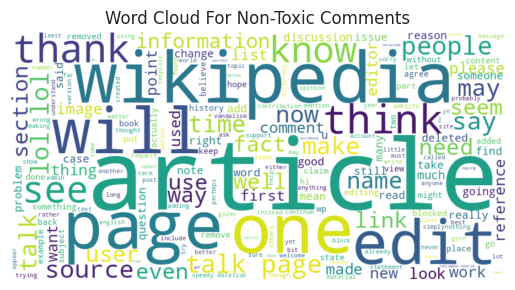

In [ ]:
# Plot word cloud for non toxic comments
generate_word_cloud(df, 0)

In [ ]:
# Define a function to plot custom histograms
def plot_hist(y, xlabel, title, bins=100):
  """
  Function to plot a custom histogram for the given data.
  Args:
    y: The data to be plotted.
    xlabel: The label for the x-axis.
    title: The title of the histogram.
    bins: The number of bins for the histogram.
  Returns:
    None
  """
  sns.histplot(y, bins=bins, kde=True, color='red')
  plt.xlabel(xlabel)
  plt.ylabel('Frequency')
  plt.title(title)
  return

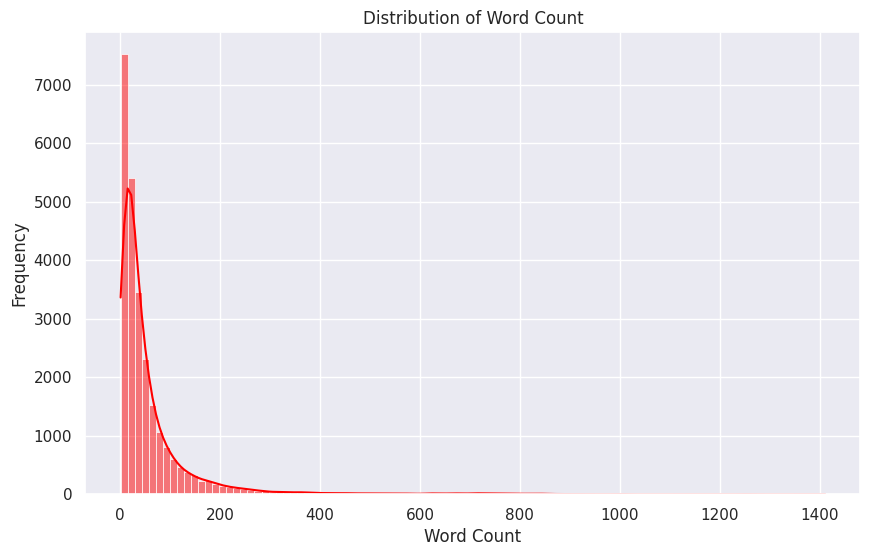

In [ ]:
# Calculate word count of each comment
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of word count
plt.figure(figsize=(10, 6))
plot_hist(df['word_count'], 'Word Count', 'Distribution of Word Count')
plt.show()

In [ ]:
# Calculate descriptive statistics for word count
df['word_count'].describe()

,word_count
count,25868.000000
mean,60.085666
std,101.457404
min,1.000000
25%,13.000000
50%,29.000000
75%,63.000000
max,1411.000000


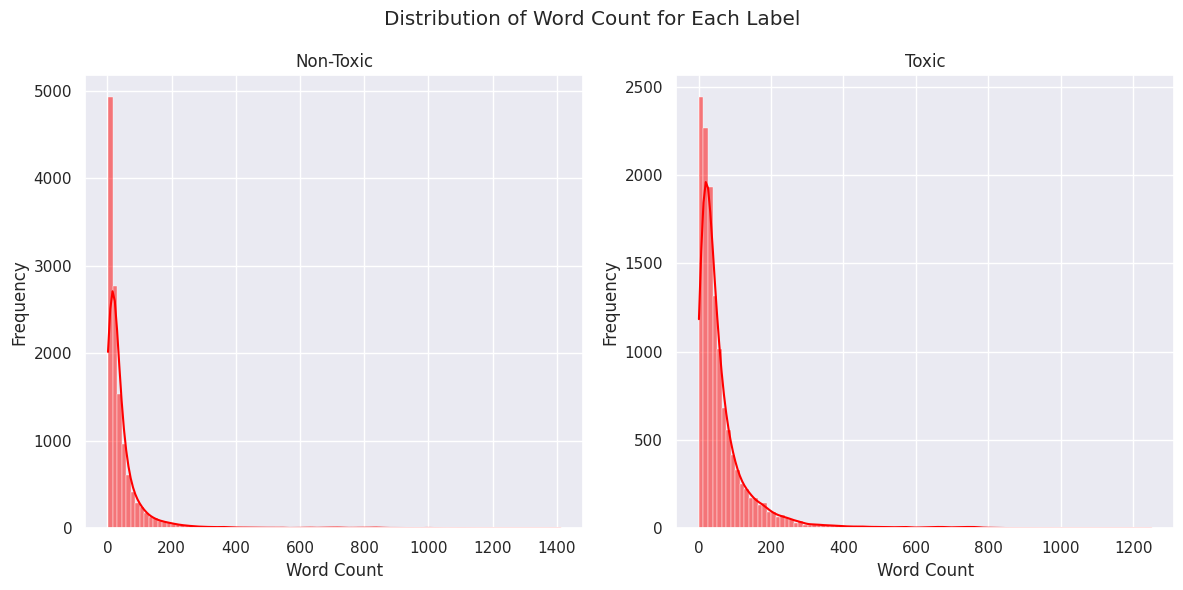

In [ ]:
# Calculate word count of each comment for each label
non_toxic_word_count = df[df['label'] == 1]['comment_text'].apply(lambda x: len(str(x).split()))
toxic_word_count = df[df['label'] == 0]['comment_text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of word count for each label
plt.figure(figsize=(12, 6))
# Subplot for non-toxic comments
plt.subplot(1, 2, 1)
plot_hist(non_toxic_word_count, 'Word Count', 'Non-Toxic')
# Subplot for toxic comments
plt.subplot(1, 2, 2)
plot_hist(toxic_word_count, 'Word Count', 'Toxic')

plt.suptitle('Distribution of Word Count for Each Label')
plt.tight_layout()
plt.show()

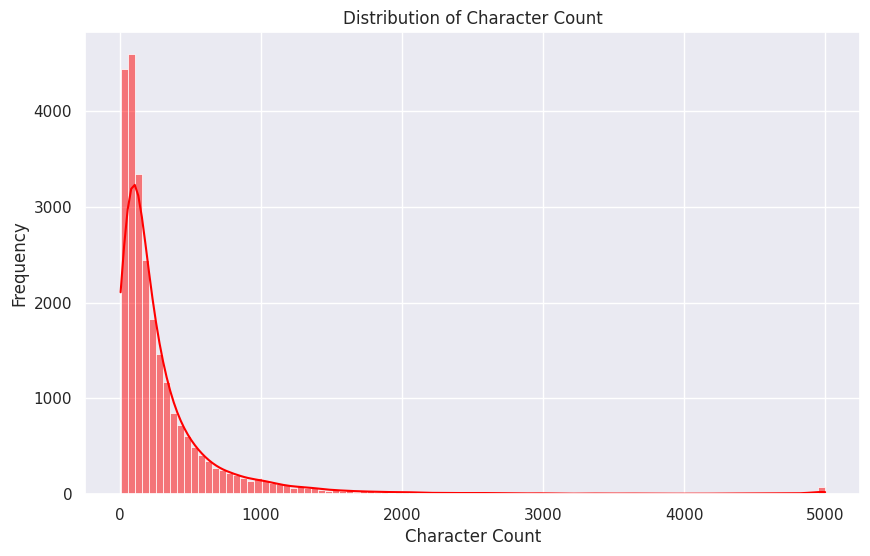

In [ ]:
# Calculate character count of each comment
chr_count = df['comment_text'].str.len()

# Plot the distribution of character count
plt.figure(figsize=(10, 6))
plot_hist(chr_count, 'Character Count', 'Distribution of Character Count')
plt.show()

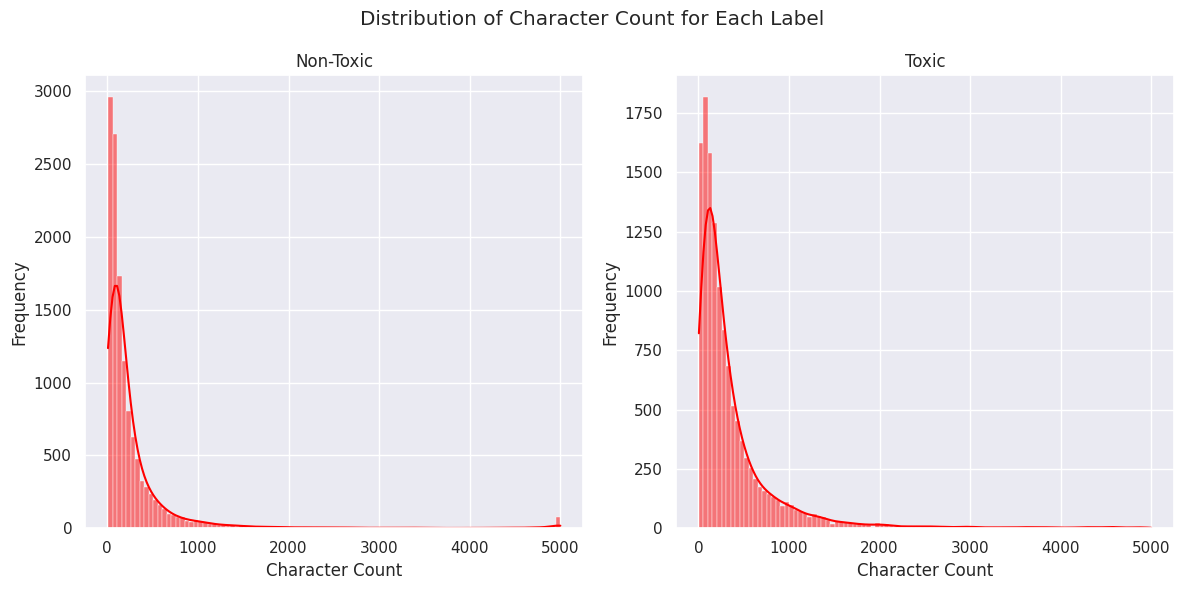

In [ ]:
# Calculate character count of each comment for each label
non_toxic_chr_count = df[df['label'] == 1]['comment_text'].str.len()
toxic_chr_count = df[df['label'] == 0]['comment_text'].str.len()

# Plot the distribution of character count for each label
plt.figure(figsize=(12, 6))
# Subplot for non-toxic comments
plt.subplot(1, 2, 1)
plot_hist(non_toxic_chr_count, 'Character Count', 'Non-Toxic')
# Subplot for toxic comment
plt.subplot(1, 2, 2)
plot_hist(toxic_chr_count, 'Character Count', 'Toxic')

plt.suptitle('Distribution of Character Count for Each Label')
plt.tight_layout()
plt.show()

In [ ]:
# Define a function to get the top n most frequent n-grams
def get_top_text_ngrams(corpus, n, g):
    """
    Function to get the top n most frequent n-grams from a text corpus.

    Args:
        corpus: List of text documents.
        n: Number of top n-grams to retrieve.
        g: N-gram order (1 for unigrams, 2 for bigrams, 3 for trigrams).

    Returns:
        A dictionary containing n-grams as keys and their corresponding counts as values.
    """
    # Create a vectorizer with the specified n-gram range
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)

    # Transform the corpus into a bag of words representation
    bag_of_words = vec.transform(corpus)

    # Calculate the sum of word occurrences across all documents
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of (word, count) tuples
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list by count in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Convert the list of tuples to a dictionary
    return dict(words_freq[:n])


# Define a function to plot the most common n-grams
def plot_common_ngrams(ngrams_dict, title):
    """
    Function to plot the most common n-grams.

    Args:
        ngrams_dict: A dictionary containing n-grams as keys and their corresponding counts as values.
        title: Title for the plot.

    Returns:
        None: Displays the horizontal bar plot.
    """
    # Extract common words and their counts from the dictionary
    common_words = list(ngrams_dict.keys())
    counts = list(ngrams_dict.values())

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(common_words, counts)
    plt.xlabel('Count')
    plt.ylabel('Common Words')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis for readability
    plt.show()
    return

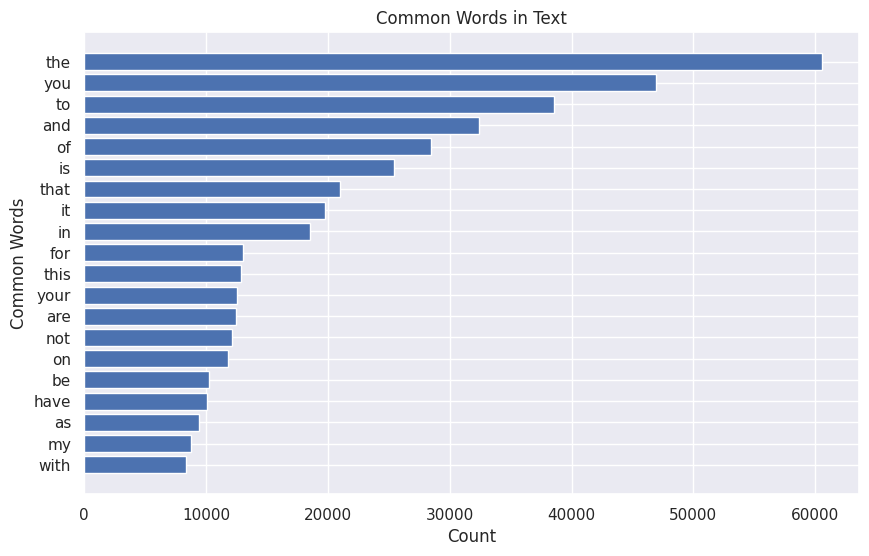

In [ ]:
# Calculate common unigrams
most_common_uni = get_top_text_ngrams(df['comment_text'], 20, 1)
# Plot common unigrams
plot_common_ngrams(most_common_uni, 'Common Words in Text')

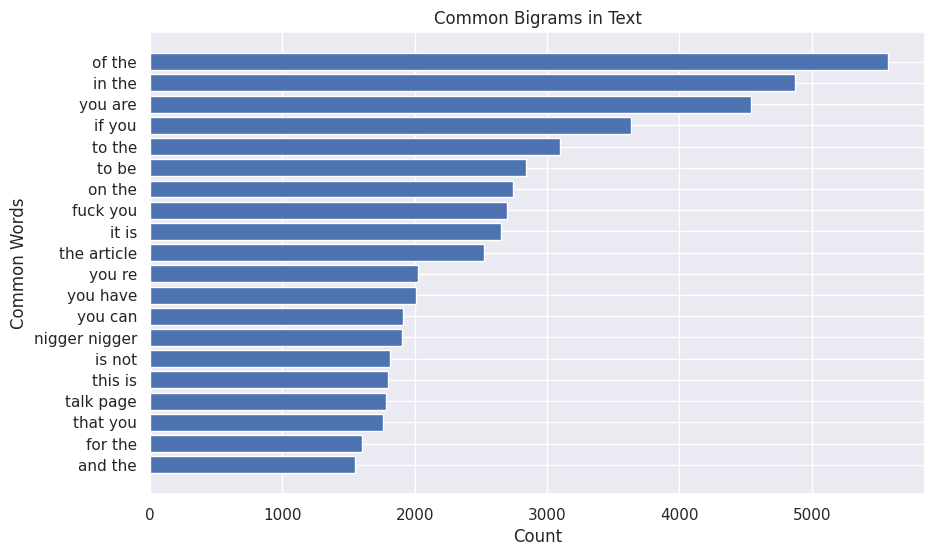

In [ ]:
# Calculate common bigrams
most_common_bi = get_top_text_ngrams(df['comment_text'], 20, 2)
# Plot common bigrams
plot_common_ngrams(most_common_bi, 'Common Bigrams in Text')

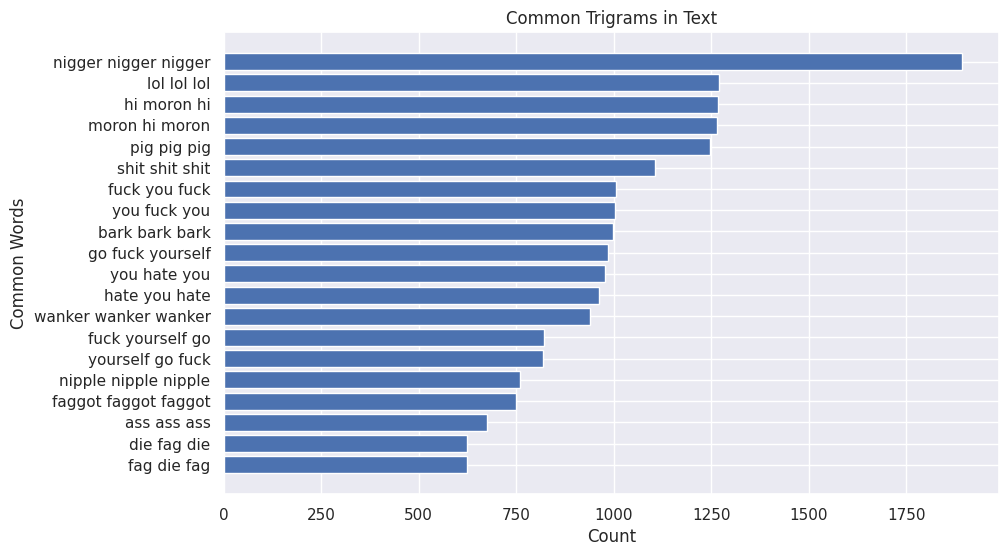

In [ ]:
# Calculate common trigrams
most_common_tri = get_top_text_ngrams(df['comment_text'], 20, 3)
# Plot common trigrams
plot_common_ngrams(most_common_tri, 'Common Trigrams in Text')

## **Pre-processing**

In [ ]:
# Set model checkpoint
model_checkpoint = "distilbert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Check if it is a fast tokenizer
tokenizer.is_fast

True

In [ ]:
# Check the maximum token length of the model
tokenizer.model_max_length

512

In order to run our experiments on GPUs found on Google Colab, we’ll pick something a bit smaller.

In [ ]:
# Tokenize a comment
inputs = tokenizer(ds[0]['comment_text'], truncation=True, max_length=128)
inputs

{'input_ids': [101, 1000, 2025, 2065, 1045, 2064, 2393, 2009, 1012, 8494, 14540, 5178, 2003, 2062, 2066, 2009, 1012, 1012, 1012, 1012, 13029, 1000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Check tokenizer
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(ds[0]['comment_text'])

['[CLS]', '"', 'not', 'if', 'i', 'can', 'help', 'it', '.', 'mud', '##sl', '##ide', 'is', 'more', 'like', 'it', '.', '.', '.', '.', '127', '"', '[SEP]']
"
Not if I can help it. Mudslide is more like it....127 "


In [ ]:
# Split to train and validation data
ds = ds.train_test_split(test_size=0.3, seed=73)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 18107
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 7761
    })
})

In [ ]:
# Double check if the dataset is balanced after splitting
Counter(ds["train"]['label']), Counter(ds["test"]['label'])

(Counter({1: 9038, 0: 9069}), Counter({1: 3896, 0: 3865}))

In [ ]:
# Define a function to tokenize
def tokenize(ex):
    return tokenizer(ex["comment_text"], truncation=True, max_length=128)

In [ ]:
# Tokenize the whole dataset
tokenized_ds = ds.map(tokenize, batched=True)
tokenized_ds

Map:   0%|          | 0/18107 [00:00<?, ? examples/s]

Map:   0%|          | 0/7761 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 18107
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7761
    })
})

In [ ]:
# Define a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
# Get lengths of each entry in a sample
samples = tokenized_ds["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["id", "comment_text"]}
[len(x) for x in samples["input_ids"]]

[11, 33, 25, 21, 43, 128, 128, 35]

In [ ]:
# Check if the data_collator is dynamically padding the sample properly
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': TensorShape([8, 128]),
 'attention_mask': TensorShape([8, 128]),
 'labels': TensorShape([8])}

In [ ]:
# Create training dataset
BATCH_SIZE = 16

train_dataset = tokenized_ds["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,  # Shuffle the dataset
    collate_fn=data_collator,  # Use the specified collate function
    batch_size=BATCH_SIZE,
)

# Create validation dataset
valid_dataset = tokenized_ds["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,  # Do not shuffle the dataset for validation
    collate_fn=data_collator,  # Use the specified collate function
    batch_size=BATCH_SIZE,
)
# Display the datasets
print('', train_dataset, '\n', valid_dataset)

 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 
 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## **Model**

In [ ]:
# Download the DistilBERT model
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                                             num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Display the model summary
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set the number of training epochs
num_epochs = 3
# Calculate the total number of training steps
num_train_steps = len(train_dataset) * num_epochs

# Create an optimizer and learning rate schedule
optimizer, schedule = create_optimizer(
    init_lr=1e-6,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

# Compile the model
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"],
              )

In [ ]:
# Fine-tune the model to our dataset
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=num_epochs,
                    )

Epoch 1/3
1132/1132 [==============================] - 295s 246ms/step - loss: 0.3802 - accuracy: 0.8528 - val_loss: 0.2291 - val_accuracy: 0.9155
Epoch 2/3
1132/1132 [==============================] - 279s 247ms/step - loss: 0.2203 - accuracy: 0.9211 - val_loss: 0.2055 - val_accuracy: 0.9229
Epoch 3/3
1132/1132 [==============================] - 287s 254ms/step - loss: 0.2021 - accuracy: 0.9249 - val_loss: 0.2010 - val_accuracy: 0.9240


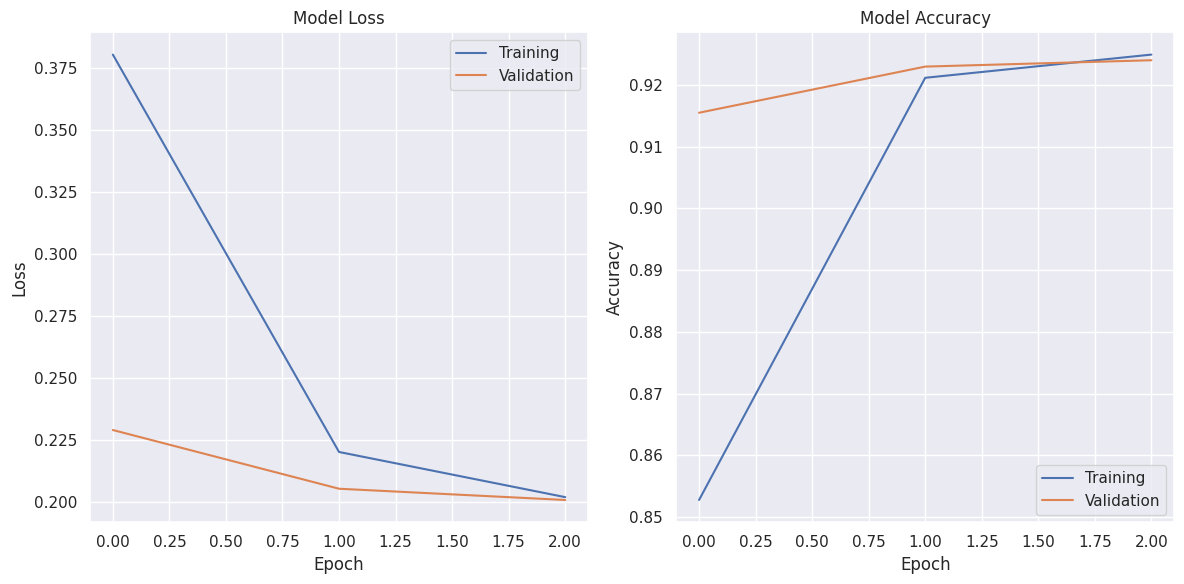

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Save the model weights
model.save_weights('/content/drive/MyDrive/llm_model.h5')

## **Model Evaluation**

In [ ]:
# Load the model weights
model.load_weights('/content/drive/MyDrive/llm_model.h5')

In [ ]:
tokenized_test = raw_ds["test"].map(tokenize, batched=True)

test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

In [ ]:
# Generate predictions
Pred = model.predict(test_dataset)

3999/3999 [==============================] - 292s 72ms/step


In [ ]:
# Get the probabilities for the positive class
y_prob = tf.nn.softmax(Pred.logits, axis=1).numpy()[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve
# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_prob)
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.9552


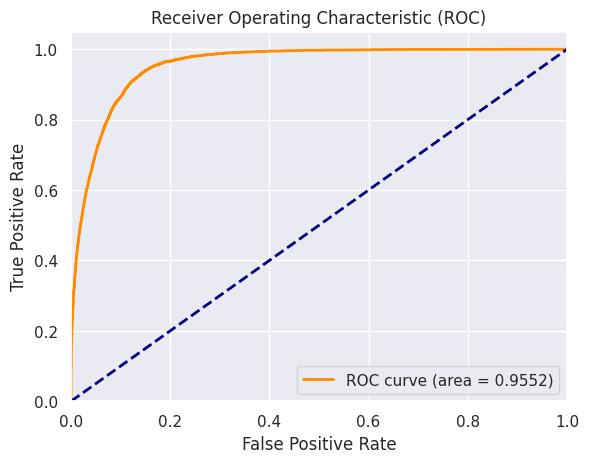

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

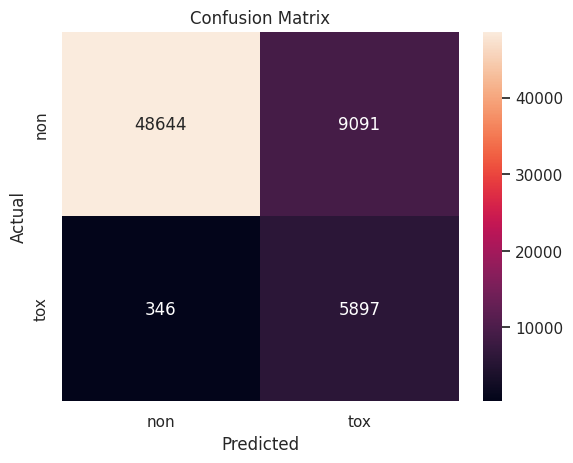

In [ ]:
# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_dataset])
y_pred = np.argmax(Pred.logits, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='rocket',
            xticklabels=label_names, yticklabels=label_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

Classification Report:
              precision    recall  f1-score   support

         non       0.99      0.84      0.91     57735
         tox       0.39      0.94      0.56      6243

    accuracy                           0.85     63978
   macro avg       0.69      0.89      0.73     63978
weighted avg       0.93      0.85      0.88     63978



## **Deployment**

In [ ]:
# initiate tokenizer
tokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    """
    Predicts the class label for a given text.

    Args:
        text (str): The input text to classify.

    Returns:
        predicted_class (int): Predicted class label (0 or 1).
        predicted_probability (float): Predicted probability.
    """
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True,
                       max_length=128)

    # Model prediction
    prediction = model(inputs)
    logits = prediction['logits'].numpy()

    # Convert logits to probabilities
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]

    # Get the predicted class and its probability
    predicted_class = np.argmax(probabilities)
    predicted_probability = probabilities[predicted_class]

    return predicted_class, predicted_probability

def on_button_click(button):
    """
    Callback function called when the button is pressed.

    Args:
        button: The button widget.
    """
    # Clear the previous output from the display.
    clear_output(wait=True)

    # Call the `predict` function
    prediction, probability = predict(text_area.value)

    # Display the prediction
    if prediction == 1:
        print(f"Prediction: Toxic with probability {probability:.4f}%")
    else:
        print(f"Prediction: Non-toxic with probability {probability:.4f}")

    # Redisplay the user interface
    display_ui()

def display_ui():
    """
    Displays the text area and button widgets.
    """
    display(text_area, button)

# Create a text area widget
text_area = widgets.Textarea(
    value='',
    placeholder='Type something',
    description='Input Text:',
    disabled=False,
    layout=widgets.Layout(height='100px', width='80%')
)

# Create a button widget
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Initially display the user interface
display_ui()

Prediction: Toxic with probability 0.9540%


Textarea(value='This whole thing sucks. This is just very badly written, badly formatted, and a whole crap tha…

Button(description='Predict', style=ButtonStyle())